In [51]:
import numpy as np

def somme_des_logs(y):
    sommes = y.copy()
    for i in range(len(y)):
        for j in range(len(y[0])):
            sommes[i][j] = som_des_logs(y[i][j])
    return sommes




In [52]:
import math

def som_des_logs(n):
    somme = 0
    for i in range(1, n+1):
        somme += math.log(i)
    return somme


In [87]:
import numpy as np
import scipy.special

def salm(nchain, x, y, alpha, beta, gamma, tau, lambd, prop_sd):

    # Initialisation
    # res = np.ones((nchain + 1, 4))
    res = []
    res.append([alpha, beta, gamma, 1/np.sqrt(tau)])
    res_lambda = []
    res_lambda.append(lambd)
    #print(res[0][1])
    n = len(x)
    m = y.shape[1]
    logmu = np.zeros((n,m))
    for l in range(n):
        for k in range(m):
            logmu[l, k] = alpha + beta * np.log(10 + x[l]) + gamma * x[l] + lambd[l, k]
    mu = np.exp(logmu)


    acc_rates = np.zeros(3)


    for i in range(nchain):


        # Mise à jour de alpha
        alpha = res[i][0]
        prop = np.random.normal(alpha, prop_sd[0])  # marche aléatoire simple
        prop_logmu = np.zeros((n,m))
        for l in range(n):
            for k in range(m):
                prop_logmu[l, k] = prop + beta * np.log(10 + x[l]) + gamma * x[l] + lambd[l, k]

        prop_mu = np.exp(prop_logmu)
        sum_log = somme_des_logs(y)
        top = - ((prop**2) / (2 * 1e6)) + np.sum(y * np.log(prop_mu) - sum_log - prop_mu)
        bottom = - ((alpha**2) / (2 * 1e6)) + np.sum(y * np.log(mu) - sum_log - mu)
        acc_prob = np.exp(top - bottom)  # la proportion des noyaux est de 1 (symétrie du noyau)

        if np.random.uniform(0, 1) < min(1, acc_prob):
            alpha = prop
            logmu = prop_logmu
            mu = prop_mu
            acc_rates[0] += 1

        # Mise à jour de beta

        beta = res[i][1]
        prop = np.random.normal(beta, prop_sd[1])  # marche aléatoire simple
        for l in range(n):
            for k in range(m):
                prop_logmu[l, k] = alpha + prop * np.log(10 + x[l]) + gamma * x[l] + lambd[l, k]
        prop_mu = np.exp(prop_logmu)
        sum_log = somme_des_logs(y)
        top = - ((prop**2) / (2 * 1e6)) + np.sum(y * np.log(prop_mu) - sum_log - prop_mu)
        bottom = - ((beta**2) / (2 * 1e6)) + np.sum(y * np.log(mu) - sum_log - mu)
        acc_prob = np.exp(top - bottom)  # la proportion des noyaux est de 1 (symétrie du noyau)

        if np.random.uniform(0, 1) < min(1, acc_prob):
            beta = prop
            logmu = prop_logmu
            mu = prop_mu
            acc_rates[1] += 1

        # Mise à jour de gamma
        gamma = res[i][2]
        prop = np.random.normal(gamma, prop_sd[2])  # marche aléatoire simple
        for l in range(n):
            for k in range(m):
                prop_logmu[l, k] = alpha + beta * np.log(10 + x[l]) + prop * x[l] + lambd[l, k]
        prop_mu = np.exp(prop_logmu)
        sum_log = somme_des_logs(y)
        top = - ((prop**2) / (2 * 1e6)) + np.sum(y * np.log(prop_mu+1e-10) - sum_log - prop_mu)
        bottom = - ((gamma**2) / (2 * 1e6)) + np.sum(y * np.log(mu) - sum_log - mu)
        acc_prob = np.exp(top - bottom)  # la proportion des noyaux est de 1 (symétrie du noyau)

        if np.random.uniform(0, 1) < min(1, acc_prob):
            gamma = prop
            logmu = prop_logmu
            mu = prop_mu
            acc_rates[2] += 1

        # Mise à jour de tau
        tau = np.random.gamma(1e-3 + (n + m) / 2, 1e-3 + 0.5 * np.sum(lambd**2))

        # Mise à jour de lambd
        for k in range(n):
            for l in range(m):
                prop = np.random.normal(lambd[k,l], prop_sd[3])
                for o in range(n):
                    for p in range(m):
                        prop_logmu[o, p] = alpha + beta * np.log(10 + x[o]) + gamma* x[o] + prop
                prop_mu = np.exp(prop_logmu)
                top = - (prop**2 *tau/ 2)- prop_mu[k,l] + np.log(prop_mu[k,l]**y[k, l]) - som_des_logs(y[k][l])
                bottom = - (lambd[k, l]**2 * tau/ 2)- mu[k,l] + np.log(mu[k, l]**y[k, l]) - som_des_logs(y[k][l])
                acc_prob = np.exp(top - bottom)

                if np.random.uniform(0, 1) < min(1, acc_prob):
                    lambd[k, l] = prop
                    logmu= prop_logmu
                    mu = prop_mu

        # Mise à jour de la chaîne de Markov et de lambd
        res.append([alpha, beta, gamma, 1/np.sqrt(tau)])
        res_lambda.append(lambd)

    my_list = {"chain": res, "acc_rates": acc_rates}
    return my_list



In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, poisson

# Récupération des données
Ndoses = 6
Nplates = 3
#y = np.array([[15, 16, 16],
 #             [27, 33, 20],
 #            [21, 18, 26],
 #             [41, 38, 27],
 #             [29, 21, 33],
  #            [60, 41, 42]])

y = np.array([[15, 21, 29],
              [16, 18, 21],
              [16, 26, 33],
              [27, 41, 69],
              [33, 38, 41],
              [20, 27, 42]])

x = np.array([0, 10, 33, 100, 333, 1000])

# Initialisation
alpha = 0.0
beta = 0
gamma = 0
tau = 0.1
lambd = np.random.normal(loc=0, scale=np.sqrt(1/tau), size=(6, 3))

resultat = salm(int(1e4), x, y, alpha, beta, gamma, tau, lambd, prop_sd=[0.38, 0.1, 0.00001, 0.08])  # prop_sd choisi pour avoir une apparence de chaîne cohérente

resultat_chain = resultat["chain"][1000:]  # enlever les 1000 premiers (burn-in)

moychain = np.mean(resultat_chain, axis=0)  # moyenne
sdchain = np.std(resultat_chain, axis=0)  # écart-type

print("alpha est estimé à", moychain[0], "avec un écart-type de", sdchain[0])
print("beta est estimé à", moychain[1], "avec un écart-type de", sdchain[1])
print("gamma est estimé à", moychain[2], "avec un écart-type de", sdchain[2])
print("sigma est estimé à", moychain[3], "avec un écart-type de", sdchain[3])



alpha est estimé à 2.0773006976958546 avec un écart-type de 0.23814433696748907
beta est estimé à 0.22313935870384927 avec un écart-type de 0.03262277802728022
gamma est estimé à -5.1626661407526726e-05 avec un écart-type de 1.1443731679727555e-05
sigma est estimé à 0.14450445029543305 avec un écart-type de 0.03974871427082831


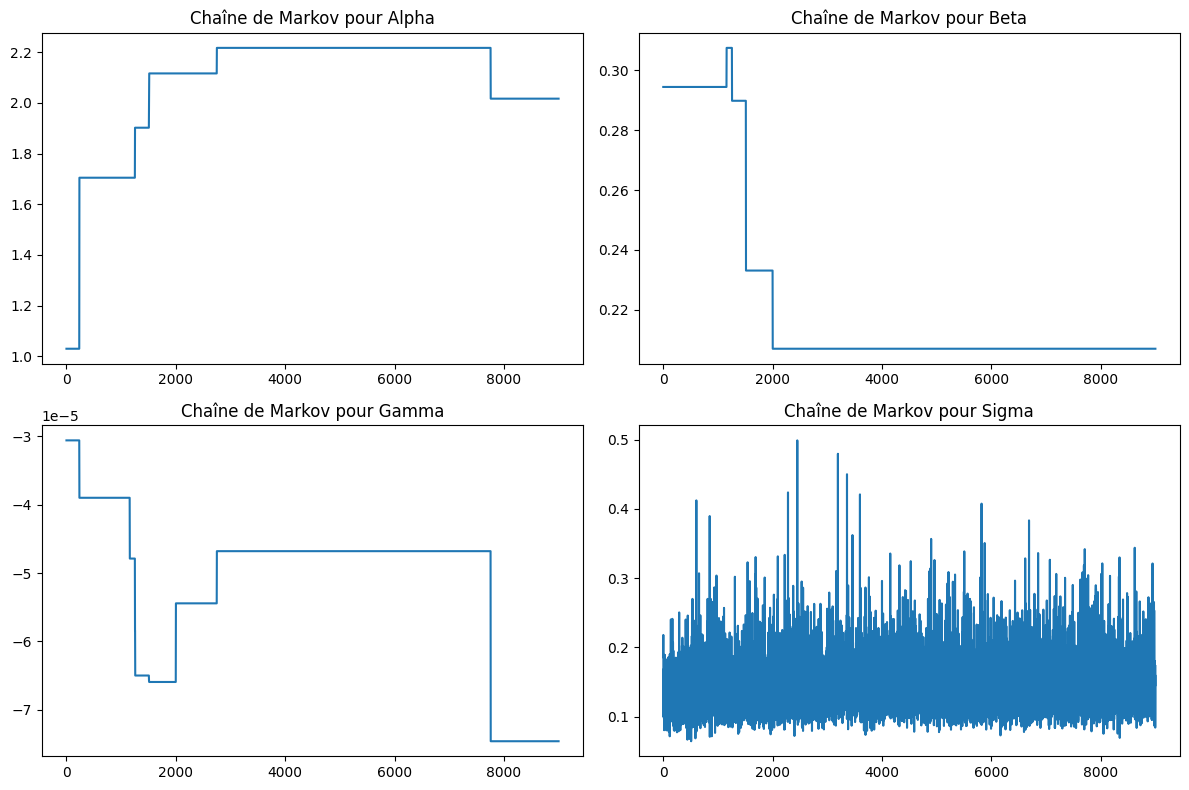

In [90]:
import matplotlib.pyplot as plt

# Obtention des chaînes de Markov pour chaque paramètre
alpha_chain = [item[0] for item in resultat_chain]
beta_chain = [item[1] for item in resultat_chain]
gamma_chain = [item[2] for item in resultat_chain]
sigma_chain = [item[3] for item in resultat_chain]

# Tracé des chaînes de Markov
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(alpha_chain)
plt.title('Chaîne de Markov pour Alpha')

plt.subplot(2, 2, 2)
plt.plot(beta_chain)
plt.title('Chaîne de Markov pour Beta')

plt.subplot(2, 2, 3)
plt.plot(gamma_chain)
plt.title('Chaîne de Markov pour Gamma')

plt.subplot(2, 2, 4)
plt.plot(sigma_chain)
plt.title('Chaîne de Markov pour Sigma')

plt.tight_layout()
plt.show()


In [91]:
mean = [moychain[0], moychain[1], moychain[2], moychain[3]]
sd = [sdchain[0], sdchain[1], sdchain[2], sdchain[3]]

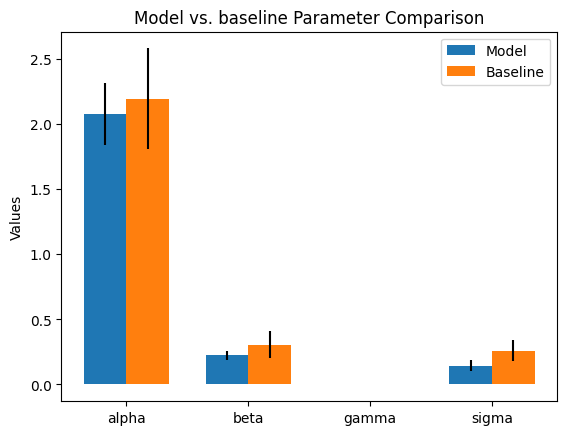

In [92]:
#Baseline here indicates Breslow and Clayton estimates
def plot_parameter_comparison(params_df):
    ind = np.arange(len(params_df))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width / 2, params_df['mean'], width, label='Model', yerr=params_df['std'])
    rects2 = ax.bar(ind + width / 2, params_df['mean_base'], width, label='Baseline', yerr=params_df['std_base'])

    # Add some text for labels, title, and custom x-axis tick labels
    ax.set_ylabel('Values')
    ax.set_title('Model vs. baseline Parameter Comparison')
    ax.set_xticks(ind)
    ax.set_xticklabels(['alpha', 'beta', 'gamma', 'sigma'])
    ax.legend()

    plt.show()

#results_summary = results.describe().T
import pandas as pd
params_df = pd.DataFrame()
params_df['mean'] = mean
params_df['std'] = sd
#Breslow and Clayton estimates
params_df['mean_base'] = [2.193, 0.3059, 69.577*(10**(-4)), 0.2608]
params_df['std_base'] = [0.3874, 0.1054, 4.525*(10**(-4)), 0.08077]
params_df.reset_index(drop=True, inplace=True)

plot_parameter_comparison(params_df)
